<h1><center> Welcome to MotEx </center></h1>



# First import modules, set seed parameters and import functions

In [1]:
import numpy as np
import time
import matplotlib as mpl
import matplotlib.cm
from multiprocessing import Pool
from functools import partial

In [8]:
formfactor_dict = {
  "H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8, "F": 9, "Ne": 10, "Na": 11, "Mg": 12,
  "Al": 13, "Si": 14, "P": 15, "S": 16, "Cl": 17, "Ar": 18, "K": 19, "Ca": 20, "Sc": 21, "Ti": 22, "V": 23, "Cr": 24,
  "Mn": 25, "Fe": 26, "Co": 27, "Ni": 28, "Cu": 29, "Zn": 30, "Ga": 31, "Ge": 32, "As": 33, "Se": 34, "Br": 35, "Kr": 36,
  "Rb": 37, "Sr": 38, "Y": 39, "Zr": 40, "Nb": 41, "Mo": 42, "Tc": 43, "Ru": 44, "Rh": 45, "Pd": 46, "Ag": 47, "Cd": 48,
  "In": 49, "Sn": 50, "Sb": 51, "Te": 52, "I": 53, "Xe": 54, "Cs": 55, "Ba": 56, "Hf": 72, "Ta": 73, "W": 74, "Re": 75,
  "Os": 76, "Ir": 77, "Pt": 78, "Au": 79, "Hg": 80, "Tl": 81, "Pb": 82, "Bi": 83, "Po": 84, "At": 85, "Rn": 86, "Fr": 87,
  "Ra": 88, "Rf": 104, "Db": 105, "Sg": 106, "Bh": 107, "Hs": 108, "Mt": 109, "Ds": 110, "Rg": 111, "Cn": 112, "Nh": 113, "Fl": 114,
  "Mc": 115, "Lv": 116, "Ts": 117, "Og": 118, "La": 57, "Ce": 58, "Pr": 59, "Nd": 60, "Pm": 61, "Sm": 62, "Eu": 63, "Gd": 64,
  "Tb": 65, "Dy": 66, "Ho": 67, "Er": 68, "Tm": 69, "Yb": 70, "Lu": 71, "Ac": 89, "Th": 90, "Pa": 91, "U": 92, "Np": 93,
  "Pu": 94, "Am": 95, "Cm": 96, "Bk": 97, "Cf": 98, "Es": 99, "Fm": 100, "Md": 101, "No": 102, "Lr": 103, "D": 1}

def Load(Experimental_Data, starting_model):
    """This function loads the data and structure"""
    
    # Get experimental data
    for skip_row in range(100):
        try:
            Exp_data = np.loadtxt(Experimental_Data, skiprows=skip_row)
        except ValueError:
            continue
    # Nyquist sampling the data by only using every 10nth datapoint
    if Exp_data[1,0] - Exp_data[0,0] < 0.1:
        Exp_r, Exp_Gr = Exp_data[::10,0], Exp_data[::10,1]
    else:
        Exp_r, Exp_Gr = Exp_data[:,0], Exp_data[:,1]
    # Normalise data
    Exp_Gr /= max(Exp_Gr)

    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    struct=[]
    with open(starting_model, 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            if len(sep_line)==4: #  tillader andre informationer i xyz filen some ikke skal laeses
                struct.append(sep_line)
    elements=np.array(struct)[:,0]
    xyz=(np.array(struct)[:,1:].astype(float))
    
    return Exp_r, Exp_Gr, elements, xyz

def fitting(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, elements, xyz, index):    
    """This function takes in a 'starting_model', and an 'index' from the 'structure_catalogue'. It generates the 
    corresponding structure and calculate the Rwp value to the 'Experimental_Data without fitting"""
    
    # Cycle through W atoms and delete W according to index 0's from permutation
    delete_M = np.where(np.array(structure_catalogue)[index,:] == 0)[0]
    
    # Delete atoms from starting model 
    elements = np.delete(elements, delete_M, 0)
    xyz = np.delete(xyz, delete_M, 0)
    elements = [int(formfactor_dict[element]) for element in elements]
    
    # Calculate distances and formfactor to simulate PDF
    i, j = np.triu_indices(len(xyz), k=1)
    dists = np.sqrt((xyz[i,0]-xyz[j,0])**2+(xyz[i,1]-xyz[j,1])**2+(xyz[i,2]-xyz[j,2])**2)
    formfactor = np.array(elements)[i] * np.array(elements)[j]
    
    # Simulate PDF
    #Sim_Gr, Sim_r = torch.histogram(torch.tensor(dists).float(), bins=301, range=[-0.05,30.05], weight=torch.tensor(formfactor).float())
    Sim_Gr, Sim_r = np.histogram(np.array(dists, dtype=float), bins=301, range=[-0.05,30.05], weights=np.array(formfactor, dtype=float))
    Sim_r = (Sim_r[1:] + Sim_r[:-1]) / 2
    
    # Normalise PDF
    #Sim_Gr /= Exp_r
    Sim_Gr = np.nan_to_num(Sim_Gr, 0)
    Sim_Gr /= np.max(Sim_Gr)

    # Calculate Rwp value
    Rwp = np.sqrt(sum((Exp_Gr[10:] - Sim_Gr[10:])**2) / sum((Exp_Gr[10:])**2))
    Rwp = np.sqrt(sum((Exp_Gr[10:100] - Sim_Gr[10:100])**2) / sum((Exp_Gr[10:100])**2))
    PCC = np.corrcoef(Exp_Gr[10:100], Sim_Gr[10:100])[0,1]

    return PCC

def fitting_multiprocess(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, element, xyz, SaveName, cores=1):
    """This function runs the calculations of all the structures in the structure catalogue using multiprocessing"""

    values = []
    # Set up multiprocessing refinement
    fitindex = range(len(structure_catalogue))
    p = Pool(processes=cores)
    func = partial(fitting, structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, element, xyz)
    results = p.map(func, fitindex)
    p.close()
    p.join()
    
    # Start calculating residuals and append results to lists
    for i in fitindex:
        rw = results[i]
        values.append(rw)
    values = np.reshape(values,(int(len(values)/1) , 1))
    
    # Save results 
    Result = np.column_stack([values, np.asarray(structure_catalogue)])
    np.savetxt(SaveName, Result)
    
    return Result

def structure_catalogue_maker(Number_of_atoms):
    """Makes a catalogue of structures"""
    
    structure_catalogue = np.ones((Number_of_atoms,Number_of_atoms))
    structure_catalogue[np.array([range(Number_of_atoms)]),np.array([range(Number_of_atoms)])] = 0
    return structure_catalogue

def calculate_atomContributionValue(Result, saveResults):
    """Calculate atom contribution value list from the result array"""
    
    # Define AtomContributionValues vector
    AtomContributionValues = Result[:,0]
    
    # Normalise the AtomContributionValues
    amin, amax = min(AtomContributionValues), max(AtomContributionValues)
    AtomContributionValues = (AtomContributionValues - amin) / (amax - amin)
    AtomContributionValues_ph = AtomContributionValues.copy()
    AtomContributionValues_ph.sort()

    # Define colormap of viridis.reverse
    norm = mpl.colors.Normalize(vmin=AtomContributionValues_ph[round((len(AtomContributionValues))/10)], vmax=AtomContributionValues_ph[-round((len(AtomContributionValues))/10)])
    cmap = matplotlib.cm.cividis_r
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # Save results to file
    f = open(saveResults+"AtomContributionValues.txt", "w")
    f.write("\nAtom contribution are calculated to: \n")
    for i in range(len(AtomContributionValues)):
        f.write("Atom # "+ str(i+1) + ":  "+ str(AtomContributionValues[i]) + "  Colorcode:  "+ mpl.colors.rgb2hex(m.to_rgba(AtomContributionValues[i]))+"\n")
    
    return m, AtomContributionValues

def Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    """Make a crystalmaker file were the atoms are colored after their atom contribution value"""
    
    # Output a crystalmaker file to visualize the results
    CrystalMaker = open(saveResults+'CrystalMaker.cmtx', 'w')

    CrystalMaker.write("MOLE  CrystalMaker molecule format\n")
    CrystalMaker.write("TITL  Molecule\n\n")
    CrystalMaker.write("! Model type\n")
    CrystalMaker.write("MODL  1\n\n")

    CrystalMaker.write("! Depth fading settings\n")
    CrystalMaker.write("DCUE  1.000000 0.212899 0.704686\n\n")

    CrystalMaker.write("! Colour definitions:\n")
    CrystalMaker.write("TYPE\n")

    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            CrystalMaker.write(element + str(iter+1) + " 1.32 ")
            rgb1 = m.to_rgba(AtomContributionValues[iter])[:-1][0]
            rgb2 = m.to_rgba(AtomContributionValues[iter])[:-1][1]
            rgb3 = m.to_rgba(AtomContributionValues[iter])[:-1][2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
        else:
            CrystalMaker.write(element + str(iter+1) + " 0.66 ")
            rgb1 = mpl.colors.to_rgb("#FF0000")[0]
            rgb2 = mpl.colors.to_rgb("#FF0000")[1]
            rgb3 = mpl.colors.to_rgb("#FF0000")[2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("! Bond Specifications\n")
    
    # Assign bonds between the atoms
    for iter, element in enumerate(elements[:NumW]):
        if iter < NumW:
            NI_elements = np.delete(np.unique(elements), np.where(np.unique(elements) == element)[0])
            for NI_element in NI_elements:
                CrystalMaker.write("BMAX " + element  + " " + str(NI_element) + "  " + str(threshold))#    " O  2.6")
                CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("ATOM\n")
    
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")
        else:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")

    CrystalMaker.close()
    
    return None



# Define variables

In [9]:
#starting_model = "Structure_Models/Database/" # Name of the starting model file
starting_model = "Structure_Models/CIF_database/"
StemName = "DanMAX_AlphaKeggin"
saveResults = "Results/"
Metal_Atoms = ["Mo", "W", "Fe"]

import glob
files = glob.glob(starting_model+"*.xyz")
files

['Structure_Models/CIF_database/YourCustomFileName_CollCode110457.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode50567.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode7799.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode110294.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode50271.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode40089.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode50273.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode15840.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode50272.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode35001.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode35000.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode35002.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode27189.xyz',
 'Structure_Models/CIF_database/YourCustomFileName_CollCode35003.xyz',
 'Str

# Make XYZ files from crystals

In [14]:
crystalfiles_path = "Structure_Models/CIF_database/"
crystalfiles = glob.glob(starting_model+"*.cif")

from diffpy.structure import loadStructure
from diffpy.structure.expansion import supercell
from diffpy.srreal.overlapcalculator import OverlapCalculator
from diffpy.srreal.structureadapter import nosymmetry

for crystalfile in crystalfiles:
    crystal = loadStructure(crystalfile)
    # CIF file gives occupancies as '?', i.e., unknonw.
    # Let's replace them all with 1.0
    crystal.occupancy = 1.0
    # now let us extract the largest cluster
    crystal222 = supercell(crystal, [2, 2, 2])
    
    #oc = OverlapCalculator()
    #oc.atomradiitable = 'covalent'
    #oc(nosymmetry(crystal222))

    # Save supercell to xyz file
    if len(crystal222.element[0]) < 3:
        crystal222.write(crystalfile[:-4] + ".xyz", format="xyz")
    else:
        elements = [crystal222.element[i][:-2] for i in range(len(crystal222))]
        these_cords = []
        for count, (element, x, y, z) in enumerate(zip(elements, crystal222.x, crystal222.y, crystal222.z)):
            if count == 0:
                these_cords.append(['{:d}'.format(len(elements))])
                these_cords.append([''])
            these_cords.append([element+'   {:.3f}   {:.3f}   {:.3f}'.format(x*crystal222.lattice.a, y*crystal222.lattice.b, z*crystal222.lattice.c)])

        np.savetxt(crystalfile[:-4] + ".xyz", these_cords, fmt='%s')


In [15]:
### First define the experimental data path and the path you want the structure catalogue with fits to be saved
Experimental_Data = "Experimental_Data/"+StemName+".gr" # Name of the experimental file
saveFits = "Training_Data/"+StemName+".txt" # Name of the saved fits file


# Run

In [16]:
Mean_Rwps = []
Mean_AtomContributionValues = []
STD_AtomContributionValues = []
for file in files[:3]:
    print ("File: ", file)
    start_time = time.time()
    # Load data and start model
    Exp_r, Exp_Gr, elements, xyz = Load(Experimental_Data, file)
    NumW = 0
    for Metal_Atom in Metal_Atoms:
        NumW += list(elements).count(Metal_Atom)
    if NumW > 0:
        print ("NumW: ", NumW)
        print ("Total number of atoms: ", len(elements))
        # Step 1: Make the structure catalogue
        structure_catalogue = structure_catalogue_maker(Number_of_atoms=NumW)
        print ("Catalogue maker: ", time.time() - start_time)

        #Result = []
        #for i in range(len(structure_catalogue)):
        #    Result.append(fitting(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, elements, xyz, i))
        #Result = np.column_stack([Result, np.asarray(structure_catalogue)])
        
        ### Step 2: Produce organized structure catalogue with Rwp values
        Result = fitting_multiprocess(structure_catalogue, formfactor_dict, Exp_r, Exp_Gr, elements, xyz, SaveName=saveFits, cores=None)
        print ("Mean Rwp: ",Result[:,0].mean(), " %")
        print ("Getting results: ", time.time() - start_time)
        
        # Step 3: Calculate Atom Contribution values
        m, AtomContributionValues = calculate_atomContributionValue(Result, saveResults)
        Mean_AtomContributionValues.append(np.mean(AtomContributionValues))
        STD_AtomContributionValues.append(np.std(AtomContributionValues))
        print ("AtomContributionValues: ", np.mean(AtomContributionValues), " +/- ", np.std(AtomContributionValues))
        print ("Calculating atom contribution values: ", time.time() - start_time)

        # Step 4: Output a CrystalMaker file
        Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, saveResults+"/"+file.replace(starting_model, "")[:-4]+"_")
        print ("Output a CrystalMaker file: ", time.time() - start_time)
        print ("\n")
        Mean_Rwps.append(Result[:,0].mean())
    else:
        print ("Not right atoms \n")
        Mean_Rwps.append(1.5)
        Mean_AtomContributionValues.append(1.5)
        STD_AtomContributionValues.append(0)

    

File:  Structure_Models/CIF_database/YourCustomFileName_CollCode110457.xyz
NumW:  384
Total number of atoms:  3728
Catalogue maker:  0.48969101905822754
Mean Rwp:  0.13401416961300944  %
Getting results:  111.97592401504517
AtomContributionValues:  0.5057625146324924  +/-  0.23116500259719533
Calculating atom contribution values:  112.05796098709106
Output a CrystalMaker file:  112.54959607124329


File:  Structure_Models/CIF_database/YourCustomFileName_CollCode50567.xyz
NumW:  192
Total number of atoms:  448
Catalogue maker:  0.02292776107788086
Mean Rwp:  0.11614731287421398  %
Getting results:  0.6201159954071045
AtomContributionValues:  0.5757263808871533  +/-  0.1572805185624221
Calculating atom contribution values:  0.660301685333252
Output a CrystalMaker file:  0.7756071090698242


File:  Structure_Models/CIF_database/YourCustomFileName_CollCode7799.xyz
NumW:  96
Total number of atoms:  240
Catalogue maker:  0.019095182418823242
Mean Rwp:  0.03265465444442446  %
Getting results:

ValueError: x and y must have same first dimension, but have shapes (27,) and (3,)

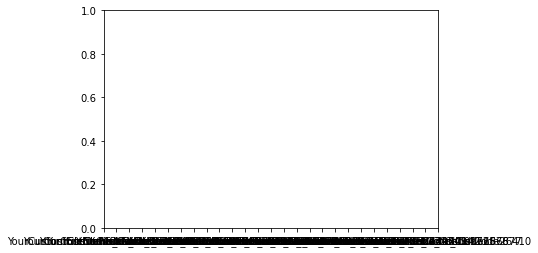

In [7]:
import matplotlib.pyplot as plt
files_ph = [file.replace(starting_model, "")[:-4] for file in files]

x = np.array(range(len(files_ph)))
plt.xticks(x, files_ph)

plt.plot(x, Mean_Rwps, "ro", label="Rwps")
plt.errorbar(x, Mean_AtomContributionValues, yerr=STD_AtomContributionValues, marker="o", label="AtomContributionValue")
plt.hlines(1.5, x[0], x[-1], label="Files without right metal atom")
plt.xticks(rotation=90)
plt.ylim(0.4, 1.1)
plt.ylabel("Rwp")
plt.legend()
plt.show()

files_sorted = [x for _, x in sorted(zip(Mean_Rwps, files))]
files_ph = [file.replace(starting_model, "")[:-4] for file in files_sorted]
print ("Top 5: ", files_ph[:5])

